In [36]:
import pandas as pd
import numpy as np
import cv2
import sklearn
import os
import seaborn as sns
import time
import pickle
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
# sns.set()
# plt.rcParams['figure.figsize'] = [10, 7]

In [37]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
train_path = '/content/drive/My Drive/Data/train_set.csv'
with open(file_path, 'r') as file:
    train_set = file.read()
test_path = '/content/drive/My Drive/Data/test_set.csv'
with open(file_path, 'r') as file:
    test_set = file.read()
val_path = '/content/drive/My Drive/Data/validation_set.csv'
with open(file_path, 'r') as file:
    val_set = file.read()

In [39]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(val_path)
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns in the train data frame')
print(f'There are {val_df.shape[0]} rows and {val_df.shape[1]} columns in the train data frame')

There are 17541 rows and 15 columns in the train data frame
There are 3407 rows and 15 columns in the train data frame
There are 4051 rows and 15 columns in the train data frame


In [40]:
train_df.head()

,image,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
test_df.head()

,image,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000009_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000015_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000016_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000018_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000020_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [42]:
val_df.head()

,image,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000013_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000013_001.png,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,00000013_002.png,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000013_003.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,00000013_004.png,0,0,1,1,0,0,0,1,0,0,1,0,0,0


In [43]:
columns = list(train_df.keys())
columns

['image',
 'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia']

In [44]:
columns.remove('image')
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
for column in columns:
    print(f"{column} - {train_df[column].sum()}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
Atelectasis - 1671
Cardiomegaly - 598
Effusion - 1613
Infiltration - 2579
Mass - 555
Nodule - 845
Pneumonia - 196
Pneumothorax - 643
Consolidation - 661
Edema - 216
Emphysema - 327
Fibrosis - 372
Pleural_Thickening - 517
Hernia - 46


In [45]:
from keras.preprocessing.image import ImageDataGenerator

In [46]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generator...")
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    return generator

In [47]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w = 320, target_h = 320):
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))
    batch = raw_train_generator.next()
    data_sample = batch[0]
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    image_generator.fit(data_sample)
    print("\ngetting valid generator...")
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [48]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "content/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "image", labels)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "image", labels)

getting train generator...
Found 0 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 0 validated image filenames.

getting valid generator...
Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 17541 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 17541 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divid


getting test generator...
Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3407 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [49]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image, ImageOps, ImageEnhance

from PIL import __version__ as PILLOW_VERSION

CKPT_PATH = '/content/drive/My Drive/Data/model.pth.tar'
N_CLASSES = 14

class DenseNet121(nn.Module):
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_ftrs, out_size)

    def forward(self, x):
        x = self.densenet121(x)
        return x

model = DenseNet121(N_CLASSES)

# Load checkpoint
if torch.cuda.is_available():
    checkpoint = torch.load(CKPT_PATH)
else:
    checkpoint = torch.load(CKPT_PATH, map_location='cpu')

print("Checkpoint keys:", checkpoint.keys())

# Load the model state dict, filtering out unnecessary keys
model_dict = model.state_dict()
checkpoint_filtered = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
model_dict.update(checkpoint_filtered)
model.load_state_dict(model_dict)

# Ensure model is in evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Checkpoint keys: dict_keys(['optimizer', 'epoch', 'arch', 'state_dict'])
Model loaded and set to evaluation mode.


Probability of Cardiomegaly: 60.5269730091095
Probability of Emphysema: 48.32744300365448
Probability of Effusion: 49.93368983268738
Probability of Hernia: 61.83101534843445
Probability of Infiltration: 48.051512241363525
Probability of Mass: 71.66439294815063
Probability of Nodule: 33.119869232177734
Probability of Atelectasis: 38.9224112033844
Probability of Pneumothorax: 73.99108409881592
Probability of Pleural_Thickening: 29.08512055873871
Probability of Pneumonia: 57.969266176223755
Probability of Fibrosis: 64.71518874168396
Probability of Edema: 49.65127110481262
Probability of Consolidation: 50.35095810890198


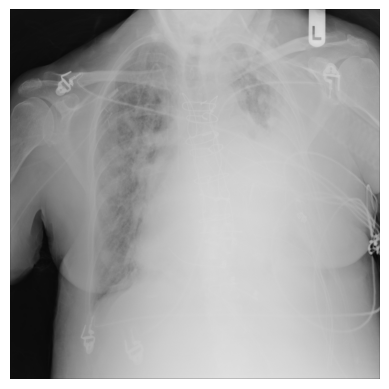

{'Mass': 0.7166439, 'Pneumothorax': 0.73991084}


<Figure size 640x480 with 0 Axes>

In [57]:
!pip install pillow
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


image_path = '/content/drive/My Drive/Data/00000032_039.png'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)

predictions = torch.sigmoid(output)

predictions_np = predictions.cpu().numpy()
detected_diseases = {}
for i in range(N_CLASSES):
    if predictions_np[0][i] > 0.7:
        detected_diseases[labels[i]] = predictions_np[0][i]
    print(f'Probability of {labels[i]}: {predictions_np[0][i] * 100}')


plt.imshow(np.array(image))
plt.axis('off')
plt.show()
plt.savefig('output_039.png')

print(detected_diseases)

Probability of Cardiomegaly: 66.84585809707642
Probability of Emphysema: 52.149224281311035
Probability of Effusion: 45.45210599899292
Probability of Hernia: 51.542794704437256
Probability of Infiltration: 54.696446657180786
Probability of Mass: 65.71010947227478
Probability of Nodule: 47.98320531845093
Probability of Atelectasis: 39.97198045253754
Probability of Pneumothorax: 61.07535362243652
Probability of Pleural_Thickening: 36.32814884185791
Probability of Pneumonia: 61.40831708908081
Probability of Fibrosis: 64.68137502670288
Probability of Edema: 71.04153633117676
Probability of Consolidation: 62.226372957229614


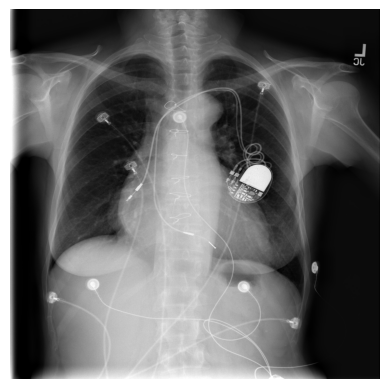

{'Edema': 0.71041536}


<Figure size 640x480 with 0 Axes>

In [58]:
!pip install pillow
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


image_path = '/content/drive/My Drive/Data/00000075_000.png'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)

predictions = torch.sigmoid(output)

predictions_np = predictions.cpu().numpy()
detected_diseases = {}
for i in range(N_CLASSES):
    if predictions_np[0][i] > 0.7:
        detected_diseases[labels[i]] = predictions_np[0][i]
    print(f'Probability of {labels[i]}: {predictions_np[0][i]*100}')


plt.imshow(np.array(image))
plt.axis('off')
plt.show()
plt.savefig('output_075.png')

print(detected_diseases)